# Predicting Customer Churn For Retail Banking
<h3><span style="color: #117d30;"> Predicting whether a retail banking customer is likely to churn</span></h3>


## Disclaimer

By accessing this code, you acknowledge the code is made available for presentation and demonstration purposes only and that the code: (1) is not subject to SOC 1 and SOC 2 compliance audits; (2) is not designed or intended to be a substitute for the professional advice, diagnosis, treatment, or judgment of a certified financial services professional; (3) is not designed, intended or made available as a medical device; and (4) is not designed or intended to be a substitute for professional medical advice, diagnosis, treatment or judgement. Do not use this code to replace, substitute, or provide professional financial advice or judgment, or to replace, substitute or provide medical advice, diagnosis, treatment or judgement. You are solely responsible for ensuring the regulatory, legal, and/or contractual compliance of any use of the code, including obtaining any authorizations or consents, and any solution you choose to build that incorporates this code in whole or in part.

© 2021 Microsoft Corporation. All rights reserved

### Introduction
In this example we use historical retail banking data to build an AutoML classification model to predict whether a retail banking customer is likely to churn or not. The objective is to predict **Churn Ratio** for the retail banking business, which is defined as the proportion of all retail banking customers that are likely to churn, in near future.  

### Importing required libraries and dependencies



In [1]:
## Importing required libraries 
import azureml.core
from azureml.core import Workspace, Datastore, Dataset, Experiment
from azureml.data import DataType
from azureml.data.datapath import DataPath

## Importing libraries specific to AutoML  
from azureml.core.compute import AmlCompute
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

## We will be reading data as a Pandas dataframe   
import pandas as pd
## Python SDK version 
print("SDK Version:", azureml.core.VERSION)

SDK Version: 1.31.0


In [2]:
import GlobalVariables 

In [3]:
## Printing the ML workspace details    
import os


ws = Workspace(subscription_id =GlobalVariables.subscription_id, 
                      resource_group =GlobalVariables.resource_group,
                      workspace_name =GlobalVariables.workspace_name)



### Pre-processing the data

#### Loading  the data
Load the historical retail banking customer dataset
 

In [4]:
## Data is already registered in ML workspace, as a tabular data     
churndata = ws.datasets['customer_churn']

#### Convert to Pandas dataframe 

In [5]:
## Converting the tabular data to a pandas dataframe 
churndata_pd = churndata.to_pandas_dataframe()
churndata_pd.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
# View info to see what the column names and types are
churndata_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

#### Set up AutoML Experiment 

In [7]:
from azureml.core.compute import ComputeTarget, ComputeInstance
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your instance
# Compute instance name should be unique across the azure region
compute_name = GlobalVariables.COMPUTE_AIML

# Verify that instance does not exist already
try:
    instance = ComputeInstance(workspace=ws, name=compute_name)
    print('Found existing instance, use it.')
except ComputeTargetException:
    compute_config = ComputeInstance.provisioning_configuration(
        vm_size='STANDARD_D3_V2',
        ssh_public_access=False,
        # vnet_resourcegroup_name='<my-resource-group>',
        # vnet_name='<my-vnet-name>',
        # subnet_name='default',
        # admin_user_ssh_public_key='<my-sshkey>'
    )
    instance = ComputeInstance.create(ws, compute_name, compute_config)
    instance.wait_for_completion(show_output=True)

Found existing instance, use it.


In [8]:
# select compute
compute = AmlCompute(ws, GlobalVariables.COMPUTE_AIML)

# choose a name for experiment
experiment_name = 'automl_churn_experiment'
experiment = Experiment(ws, experiment_name)
print(experiment)

Experiment(Name: automl_churn_experiment,
Workspace: amlws-zquzavzvs5x6m-pm0208)


#### Set up AutoML Configuration

In [9]:
## Define the target variable or the label 
label= 'y'  

## Setting up AutoML configuration
automl_config = AutoMLConfig(task='classification',
                            primary_metric='AUC_weighted',   
                            debug_log='automl_errors.log',
                            iteration_timeout_minutes = 15,
                            experiment_timeout_minutes = 15,
                            label_column_name=label,
                            enable_early_stopping=True,
                            compute_target=compute,
                            training_data=churndata,
                            n_cross_validations=5,
                            model_explainability=True)

#### Configure the AutoML model and run it

In [10]:
## Run experiment
## This code clock takes approx.25-30 minutes  
training_run = experiment.submit(automl_config, show_output = True)

Submitting remote run.
No run_configuration provided, running on cpuShellzquzavzvs5x6m with default configuration
Running on remote compute: cpuShellzquzavzvs5x6m


Experiment,Id,Type,Status,Details Page,Docs Page
automl_churn_experiment,AutoML_2b9e7433-75ba-4857-ba62-866797e1789f,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation



Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturization. Beginning to fit featurizers and featurize the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       ALERTED
DESCRIPTION:  To decrease model bias, please cancel the current run and fix balancing problem.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData
DETAILS:      Imbalanced data can lead to a falsely perceived positive effect of a model's accuracy because the input data has bias towards one class.
+---------------------------------+---------------------------------+--------------------------------------+
|Size of the smallest class       |Name/Label of the sm

### Results

#### Monitor Runs

In [11]:
# Print training runs
from azureml.widgets import RunDetails
RunDetails(training_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [12]:
## Show training run outputs
training_run.wait_for_completion(show_output=False)

{'runId': 'AutoML_2b9e7433-75ba-4857-ba62-866797e1789f',
 'target': 'cpuShellzquzavzvs5x6m',
 'status': 'Completed',
 'startTimeUtc': '2021-08-03T01:04:56.643196Z',
 'endTimeUtc': '2021-08-03T01:30:46.833242Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'AUC_weighted',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '5',
  'target': 'cpuShellzquzavzvs5x6m',
  'AMLSettingsJsonString': '{"path":null,"name":"automl_churn_experiment","subscription_id":"3f01ab49-a56f-4ee7-97fa-d23155156b42","resource_group":"media-test","workspace_name":"amlws-zquzavzvs5x6m-pm0208","region":"westus2","compute_target":"cpuShellzquzavzvs5x6m","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":false,"enable_run_restructure":false,"start_auxiliary_runs_before_parent_complete":false,"enable_code_generation":false,"iterations":1000,"

### Retrieve the Best Model from AutoML Run

In [13]:
best_run, fitted_model = training_run.get_output()
fitted_model

Package:azureml-automl-runtime, training version:1.32.0, current version:1.31.0
Package:azureml-core, training version:1.32.0, current version:1.31.0
Package:azureml-dataset-runtime, training version:1.32.0, current version:1.31.0
Package:azureml-defaults, training version:1.32.0, current version:1.31.0
Package:azureml-interpret, training version:1.32.0, current version:1.31.0
Package:azureml-mlflow, training version:1.32.0, current version:1.31.0
Package:azureml-pipeline-core, training version:1.32.0, current version:1.31.0
Package:azureml-telemetry, training version:1.32.0, current version:1.31.0
Package:azureml-train-automl-client, training version:1.32.0, current version:1.31.0
Package:azureml-train-automl-runtime, training version:1.32.0, current version:1.31.0


PipelineWithYTransformations(Pipeline={'memory': None,
                                       'steps': [('datatransformer',
                                                  DataTransformer(enable_dnn=False, enable_feature_sweeping=True, feature_sweeping_config={}, feature_sweeping_timeout=86400, featurization_config=None, force_text_dnn=False, is_cross_validation=True, is_onnx_compatible=False, observer=None, task='classification', working_dir='/mn...
    cost_mode_param=None,
    iteration_timeout_mode=0,
    iteration_timeout_param=None,
    feature_column_names=None,
    label_column_name=None,
    weight_column_name=None,
    cv_split_column_names=None,
    enable_streaming=None,
    timeseries_param_dict=None,
    gpu_training_param_dict={'processing_unit_type': 'cpu'}
), random_state=None))],
                                       'verbose': False},
                             y_transformer={},
                             y_transformer_name='LabelEncoder')

### Calculate metrics for the prediction

Now visualize the data on a scatter plot to show what our actual values are compared to the predicted values 
from the trained model that was returned.

In [14]:
# We'll get prediction for complete dataset as test   
X_test_df = churndata.drop_columns(columns=['y']).to_pandas_dataframe()
y_test_df = churndata.keep_columns(columns=['y'], validate=True).to_pandas_dataframe()

In [15]:
# call the predict functions on the model
y_pred = fitted_model.predict(X_test_df)
y_pred

array(['no', 'no', 'no', ..., 'no', 'yes', 'no'], dtype=object)

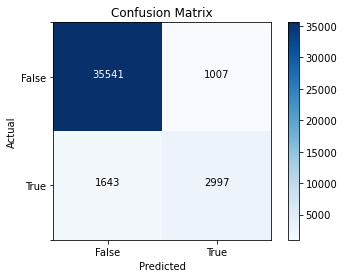

In [16]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

cf =confusion_matrix(y_test_df.values,y_pred)
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
class_labels = ['False','True']
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks,class_labels)
plt.yticks([-0.5,0,1,1.5],['','False','True',''])
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()

## Calculate the Churn Ratio 

Churn ratio is defined here as the percentage of all the retail customers who are likely to churn 

In [17]:
# Churn Ratio 
churn_predicted = pd.DataFrame(y_pred, columns = ['Churn_Predicted'])
(churn_predicted['Churn_Predicted'].value_counts()/churn_predicted['Churn_Predicted'].count())*100

no    90.28
yes    9.72
Name: Churn_Predicted, dtype: float64

## Predicted Churn Ratio is 4.03% 